<a href="https://colab.research.google.com/github/thedeveloper2104/NASH_2023_bro_code/blob/main/NASH_Bro_Code_Energy_Streamliner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics

In [55]:
## Load data using pandas read_csv method
df = pd.read_csv('consumption_data.csv')

#Setting index to Datetime
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

#Visualizing dataset first 5 records
df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [56]:
#Checking % of Null values within dataset
missed = pd.DataFrame()

missed['column'] = df.columns

missed['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]

missed = missed.sort_values('percent',ascending=False)
print(missed)

                   column  percent
0             Temperature      0.0
1                Humidity      0.0
2               WindSpeed      0.0
3     GeneralDiffuseFlows      0.0
4            DiffuseFlows      0.0
5  PowerConsumption_Zone1      0.0
6  PowerConsumption_Zone2      0.0
7  PowerConsumption_Zone3      0.0


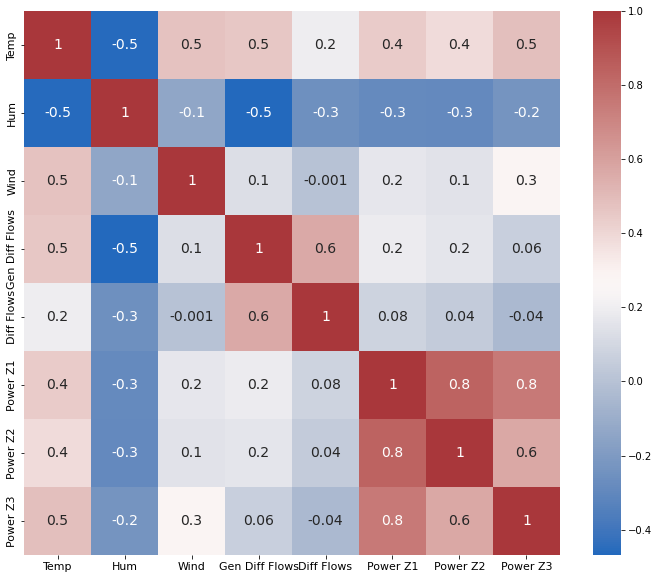

In [57]:
##Correlation Matrix

#Renaming axis labels
axis_labels = ['Temp', 'Hum', 'Wind', 'Gen Diff Flows', 'Diff Flows', 'Power Z1', 'Power Z2', 'Power Z3']

#Setting dimensions and generating heatmap with Seaborn
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, ax=ax, cmap = 'vlag', fmt='.1g', annot_kws={
                'fontsize': 14,
                'fontweight': 'regular',
            }, xticklabels= axis_labels, yticklabels=axis_labels)

#Setting Fontsize for labels
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

#Generating plot
plt.show()

In [58]:
## Feature Engineering extracts the hour, day of the week, quarter, month etc. from the datetime index

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [59]:
#Calculating 10-day, 15-day and 30-day Simple Moving Average

df['SMA10'] = df['PowerConsumption_Zone1'].rolling(10).mean()
df['SMA15'] = df['PowerConsumption_Zone1'].rolling(15).mean()
df['SMA30'] = df['PowerConsumption_Zone1'].rolling(30).mean()

df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,SMA10,SMA15,SMA30
Datetime,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,0,6,1,1,2017,1,1,52,NaN,NaN,NaN
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,0,6,1,1,2017,1,1,52,NaN,NaN,NaN
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,0,6,1,1,2017,1,1,52,NaN,NaN,NaN
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,0,6,1,1,2017,1,1,52,NaN,NaN,NaN
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,0,6,1,1,2017,1,1,52,NaN,NaN,NaN


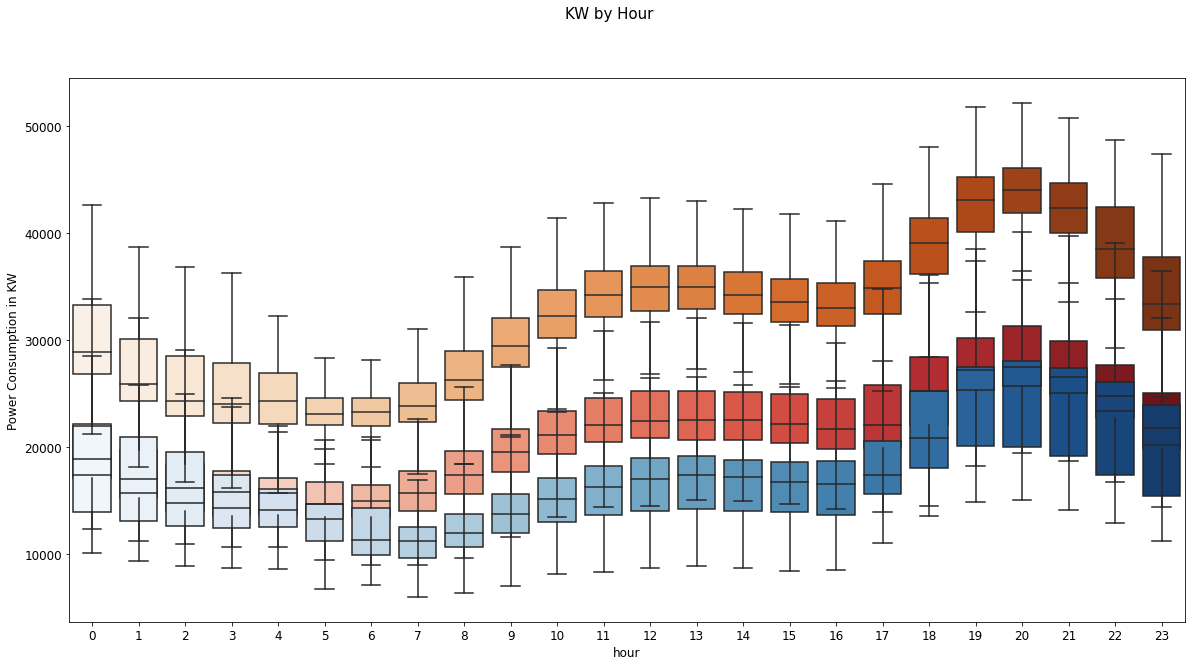

In [60]:
fig, ax = plt.subplots(figsize=(20, 10))

zone1 = sns.boxplot(data=df, x='hour', y='PowerConsumption_Zone1', palette = 'Oranges', showfliers=False)
zone2 = sns.boxplot(data=df, x='hour', y='PowerConsumption_Zone2', palette = 'Reds', showfliers=False)
zone3 = sns.boxplot(data=df, x='hour', y='PowerConsumption_Zone3', palette = 'Blues', showfliers=False)

plt.suptitle('KW by Hour', fontsize=15)
plt.xlabel('hour', fontsize=12)
plt.ylabel('Power Consumption in KW', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Generating plot
plt.show()

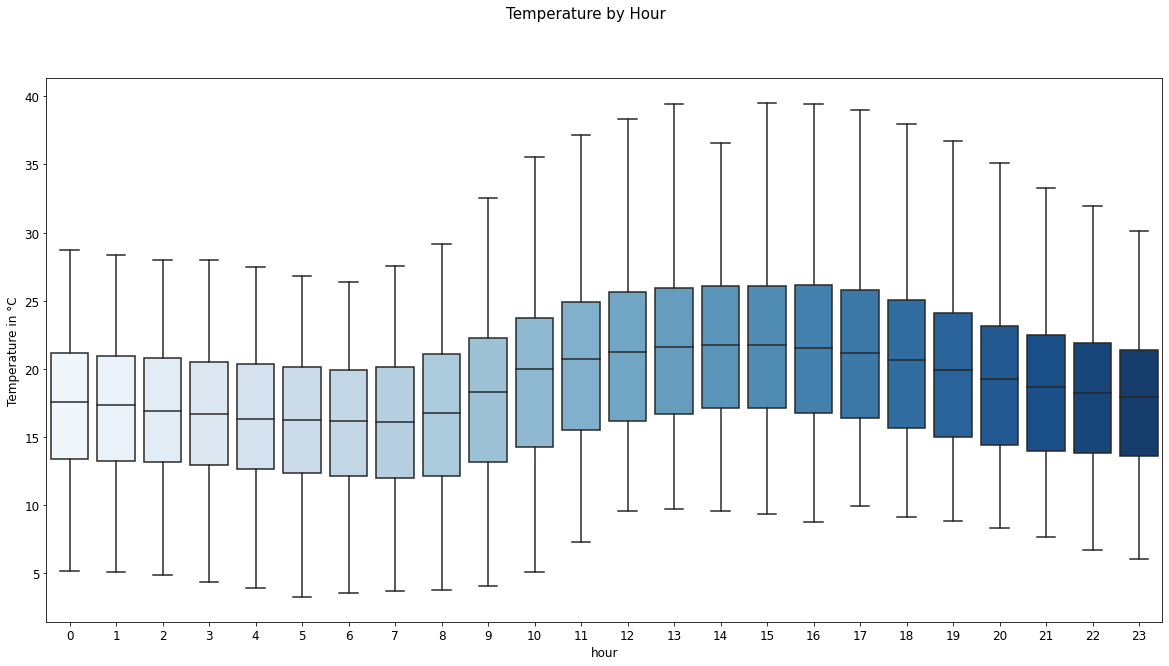

In [61]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.boxplot(data=df, x='hour', y='Temperature', palette = 'Blues', showfliers=False)

plt.suptitle('Temperature by Hour', fontsize=15)
plt.xlabel('hour', fontsize=12)
plt.ylabel('Temperature in °C', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Generating plot
plt.show()

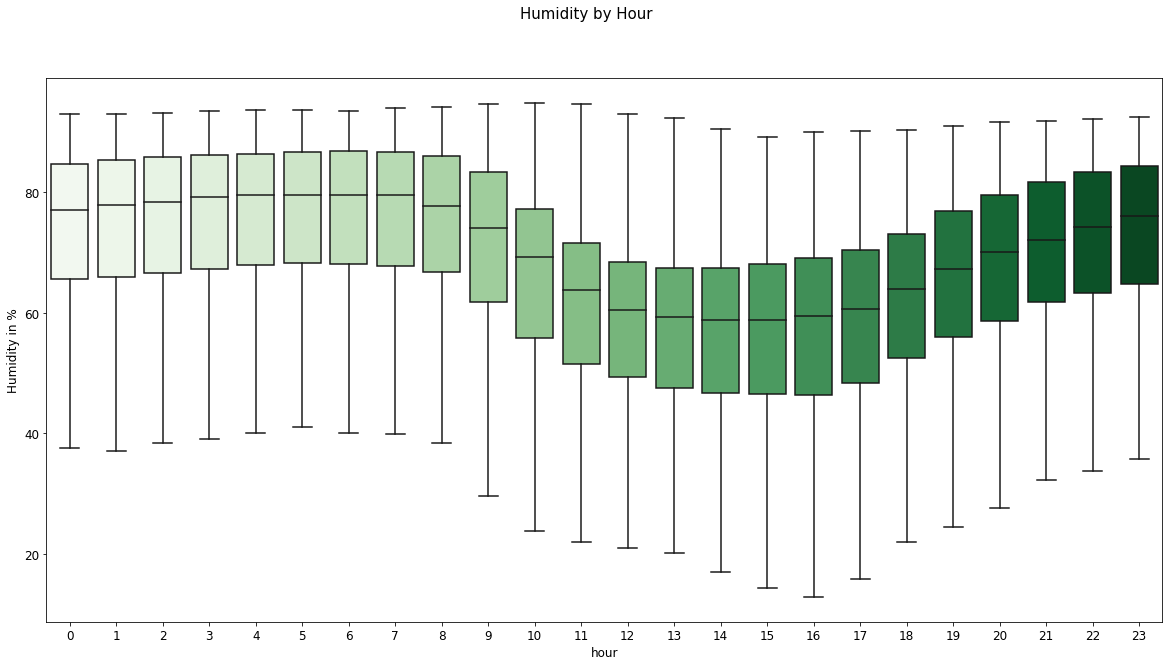

In [62]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.boxplot(data=df, x='hour', y='Humidity', palette = 'Greens', showfliers=False)

plt.suptitle('Humidity by Hour', fontsize=15)
plt.xlabel('hour', fontsize=12)
plt.ylabel('Humidity in %', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Generating plot
plt.show()

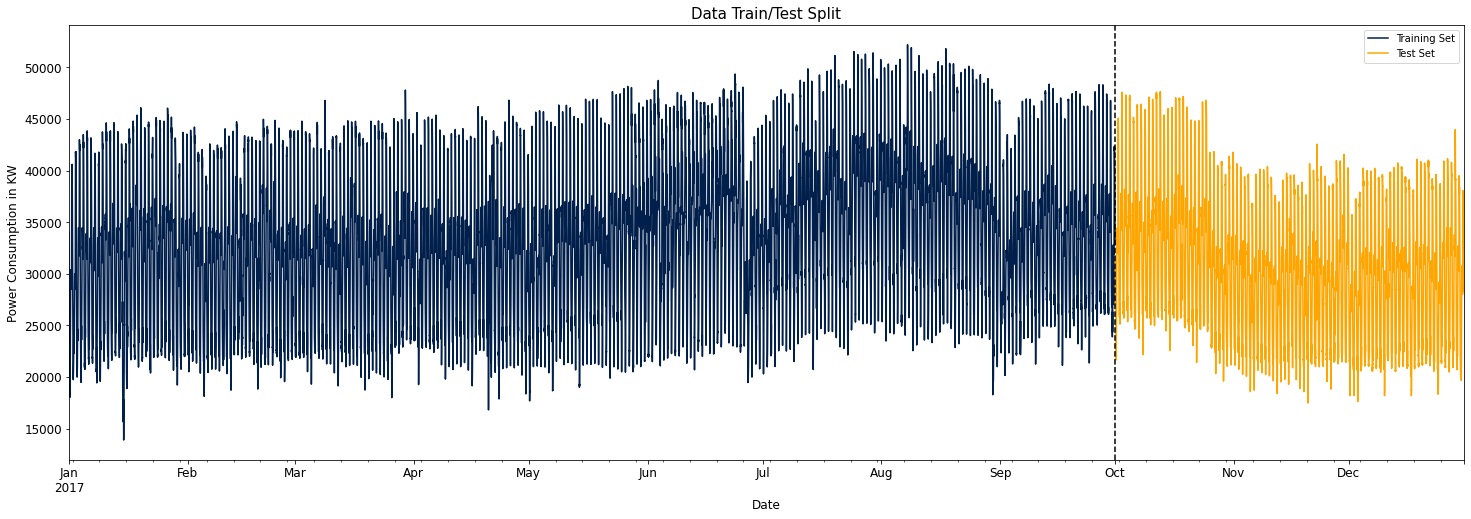

In [63]:
#Train and Test Split
zone_1 = df['PowerConsumption_Zone1']

train = zone_1.loc[zone_1.index < '10-01-2017']
test = zone_1.loc[zone_1.index >= '10-01-2017']

fig, ax = plt.subplots(figsize=(25, 8))

train.plot(ax=ax, label='Training Set', title='Data Train/Test Split', color = "#011f4b")
test.plot(ax=ax, label='Test Set', color="orange")

ax.axvline('10-01-2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])

plt.title('Data Train/Test Split', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Consumption in KW', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Generating plot
plt.show()

In [64]:
## Defining input and target variable

#Training data goes from 1st January until 30th of September, input variables are all the columns in the dataset apart from Zone 1,2,3 consumption
X_train = df.loc[:'10-01-2017',['Humidity', 'Temperature', 'WindSpeed','dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year','SMA10', 'SMA30', 'SMA15']]
y_train = df.loc[:'10-01-2017', ['PowerConsumption_Zone1']]

#Testing data goes from 1st January until 30th of September, input variables are all the columns in the dataset apart from Zone 1,2,3 consumption
X_test = df.loc['10-01-2017':,['Humidity', 'Temperature', 'WindSpeed','dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year','SMA10', 'SMA30', 'SMA15']]
y_test = df.loc['10-01-2017':, ['PowerConsumption_Zone1']]

In [65]:
#Defining Linera Regressor model and fitting

from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
# X_train.shape

X_train_liner = X_train.copy()
Y_train_liner = y_train.copy()
X_test_linear = X_test.copy()
y_test_linear = y_test.copy()

X_train_liner = X_train_liner.fillna(0)
Y_train_liner = Y_train_liner.fillna(0)

regr = LinearRegression()
regr.fit(X_train_liner, Y_train_liner)
prediction = regr.predict(X_test)
# print(prediction)
# # print(accuracy_score(y_test, prediction))
# plt.plot(prediction.flatten(), y_test)

In [66]:
y_test_linear['prediction'] = prediction
df_linear = df.merge(y_test_linear[['prediction']], how='left', left_index=True, right_index=True)

df_linear.tail()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,SMA10,SMA15,SMA30,prediction
Datetime,,,,,,,,,,,,,,,,,,,,
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,23,5,4,12,2017,364,30,52,33634.068441,34403.447401,35936.121673,32247.125704
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,23,5,4,12,2017,364,30,52,33217.946768,33990.570342,35683.041825,31885.599817
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,23,5,4,12,2017,364,30,52,32730.038022,33540.380227,35402.382763,31412.350567
2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504,23,5,4,12,2017,364,30,52,32133.840303,33082.078579,35107.528517,30691.691904
2017-12-30 23:50:00,6.580,74.1,0.081,0.062,0.111,28349.80989,24055.23167,13345.49820,23,5,4,12,2017,364,30,52,31495.057033,32597.820025,34796.451204,29905.966524


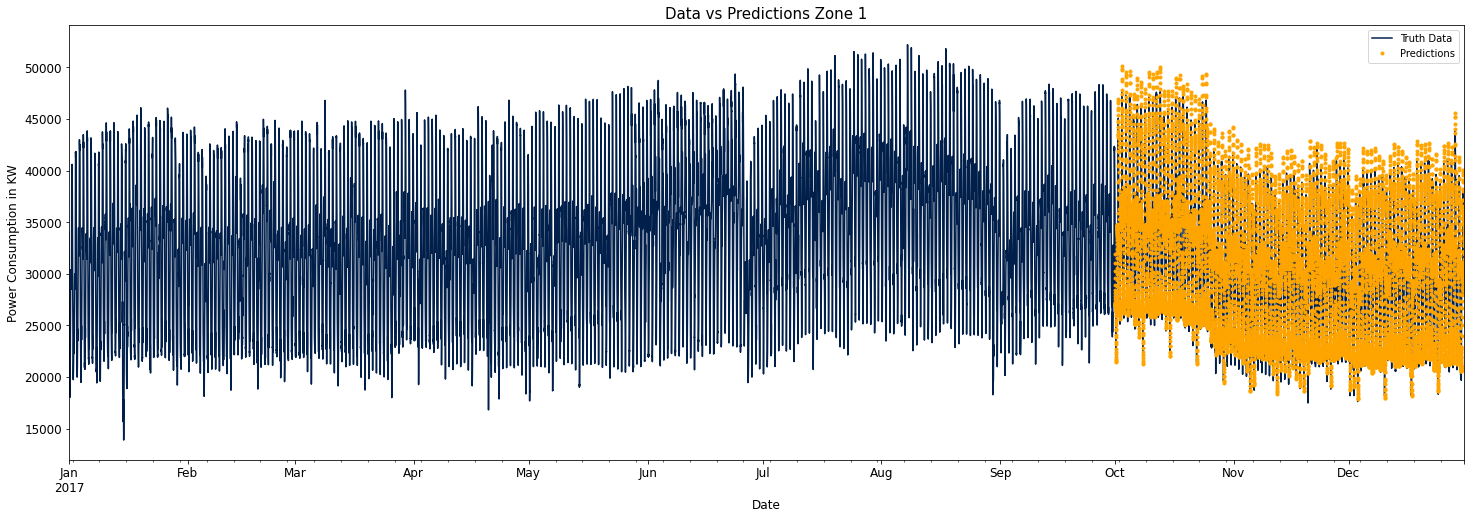

In [67]:
##Printing predictions on chart to visually assess accuracy
ax_linear = df_linear[['PowerConsumption_Zone1']].plot(figsize=(25, 8), color = "#011f4b")
y_test_linear['prediction'].plot(ax=ax_linear, style='.', color = "orange")
plt.legend(['Truth Data', 'Predictions'])

plt.title('Data vs Predictions Zone 1', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Consumption in KW', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

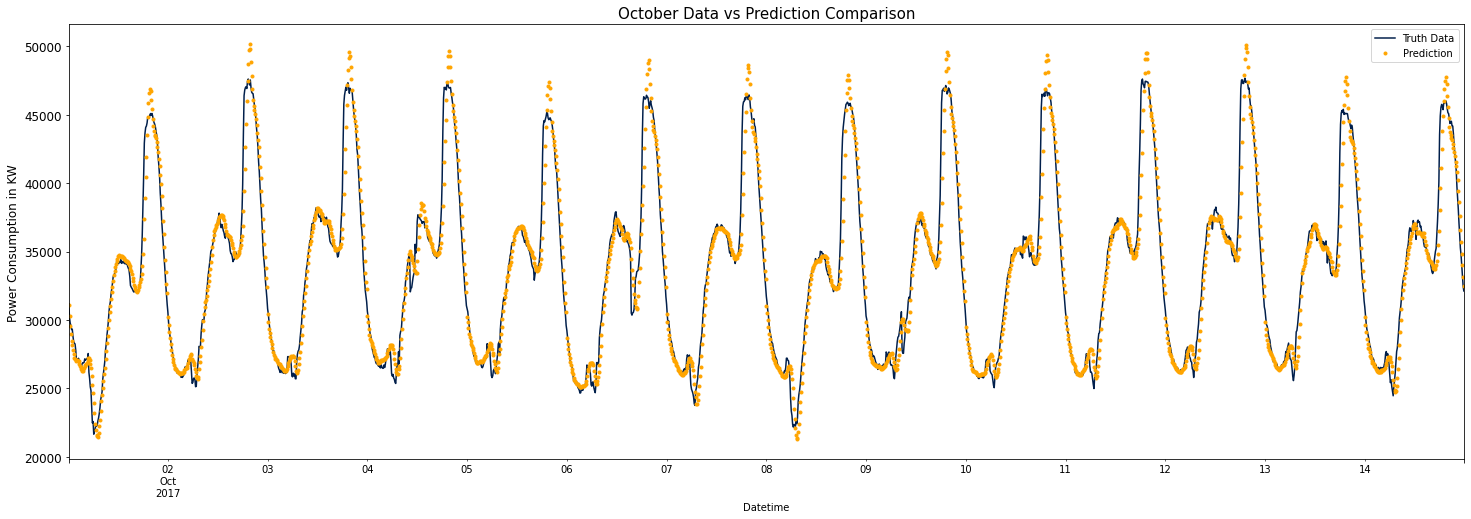

In [68]:
##Printing October predictions on chart to visually assess accuracy
ax_linear = df_linear.loc[(df.index > '10-01-2017') & (df_linear.index < '10-15-2017')]['PowerConsumption_Zone1'] \
    .plot(figsize=(25, 8), title='October Data vs Prediction Comparison', color = "#011f4b")
df_linear.loc[(df_linear.index > '10-01-2017') & (df_linear.index < '10-15-2017')]['prediction'] \
    .plot(style='.', color = "orange")

plt.title('October Data vs Prediction Comparison', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Power Consumption in KW', fontsize=12)
plt.legend(['Truth Data','Prediction'])

plt.show()

In [69]:
##Function to calculate regression metrics, evaluating accuracy
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    mape = (1- metrics.mean_absolute_percentage_error(y_true, y_pred))


    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('MAPE: ', round(mape,4))

In [70]:
#Apply function and print results
regression_results(y_test_linear['PowerConsumption_Zone1'], y_test_linear['prediction'])

explained_variance:  0.965
mean_squared_log_error:  0.0014
r2:  0.9649
MAE:  783.8716
MSE:  1460799.6346
RMSE:  1208.6354
MAPE:  0.9746


In [71]:
X_test

,Humidity,Temperature,WindSpeed,dayofyear,hour,dayofweek,quarter,month,year,SMA10,SMA30,SMA15
Datetime,,,,,,,,,,,,
2017-10-01 00:00:00,87.6,18.120,4.916,274,0,6,4,10,2017,35228.942893,39190.060611,36713.147770
2017-10-01 00:10:00,88.5,18.000,4.916,274,0,6,4,10,2017,34494.208554,38817.290757,36110.333727
2017-10-01 00:20:00,88.4,18.010,4.916,274,0,6,4,10,2017,33719.187621,38416.861951,35444.130981
2017-10-01 00:30:00,88.4,18.160,4.914,274,0,6,4,10,2017,32977.094478,38007.019693,34758.676555
2017-10-01 00:40:00,89.1,18.180,4.917,274,0,6,4,10,2017,32310.368427,37591.290951,34120.068627
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-30 23:10:00,72.4,7.010,0.080,364,23,5,4,12,2017,33634.068441,35936.121673,34403.447401
2017-12-30 23:20:00,72.6,6.947,0.082,364,23,5,4,12,2017,33217.946768,35683.041825,33990.570342
2017-12-30 23:30:00,72.8,6.900,0.086,364,23,5,4,12,2017,32730.038022,35402.382763,33540.380227


In [72]:
#Defining XGB model and fitting
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1500,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.3, 
                       random_state = 48)

reg.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:23719.59582	validation_1-rmse:21616.11490
[100]	validation_0-rmse:881.79961	validation_1-rmse:1773.11712
[200]	validation_0-rmse:763.95920	validation_1-rmse:1718.87862
[300]	validation_0-rmse:708.21702	validation_1-rmse:1649.12659
[400]	validation_0-rmse:669.16003	validation_1-rmse:1593.25154
[500]	validation_0-rmse:638.71394	validation_1-rmse:1632.04601
[600]	validation_0-rmse:614.72216	validation_1-rmse:1625.38624
[700]	validation_0-rmse:596.85851	validation_1-rmse:1610.59038
[800]	validation_0-rmse:578.20005	validation_1-rmse:1588.95515
[900]	validation_0-rmse:563.27460	validation_1-rmse:1558.68851
[1000]	validation_0-rmse:549.02639	validation_1-rmse:1548.46740
[1100]	validation_0-rmse:536.64072	validation_1-rmse:1557.06196
[1200]	validation_0-rmse:526.96109	validation_1-rmse:1570.76213
[1300]	validation_0-rmse:515.22845	validation_1-rmse:1672.68439
[1400]	validation_0-rmse:503.88074	validation_1-rmse:1649.49778
[1499]	validation_0-rmse:493.73905	validation_1-r

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=48, ...)

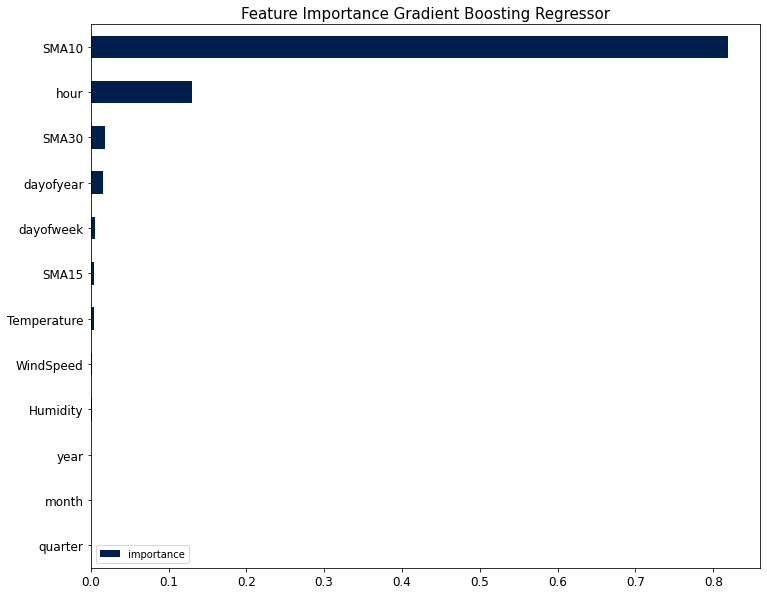

In [73]:
##Assessing Feature Importance
fi = pd.DataFrame(data=reg.feature_importances_,
             index=X_train.columns,
             columns=['importance'])

fi.sort_values('importance').plot(kind='barh', title='Feature Importance', color = "#011f4b", figsize=(12,10))
plt.title('Feature Importance Gradient Boosting Regressor', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Generating plot
plt.show()

In [74]:
##Merging predictions with original dataset
y_test = pd.DataFrame(y_test)
y_test['prediction'] = reg.predict(X_test)
df = df.merge(y_test[['prediction']], how='left', left_index=True, right_index=True)

df.tail()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,SMA10,SMA15,SMA30,prediction
Datetime,,,,,,,,,,,,,,,,,,,,
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,23,5,4,12,2017,364,30,52,33634.068441,34403.447401,35936.121673,31808.283203
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,23,5,4,12,2017,364,30,52,33217.946768,33990.570342,35683.041825,31943.707031
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,23,5,4,12,2017,364,30,52,32730.038022,33540.380227,35402.382763,31896.312500
2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504,23,5,4,12,2017,364,30,52,32133.840303,33082.078579,35107.528517,31595.556641
2017-12-30 23:50:00,6.580,74.1,0.081,0.062,0.111,28349.80989,24055.23167,13345.49820,23,5,4,12,2017,364,30,52,31495.057033,32597.820025,34796.451204,29997.041016


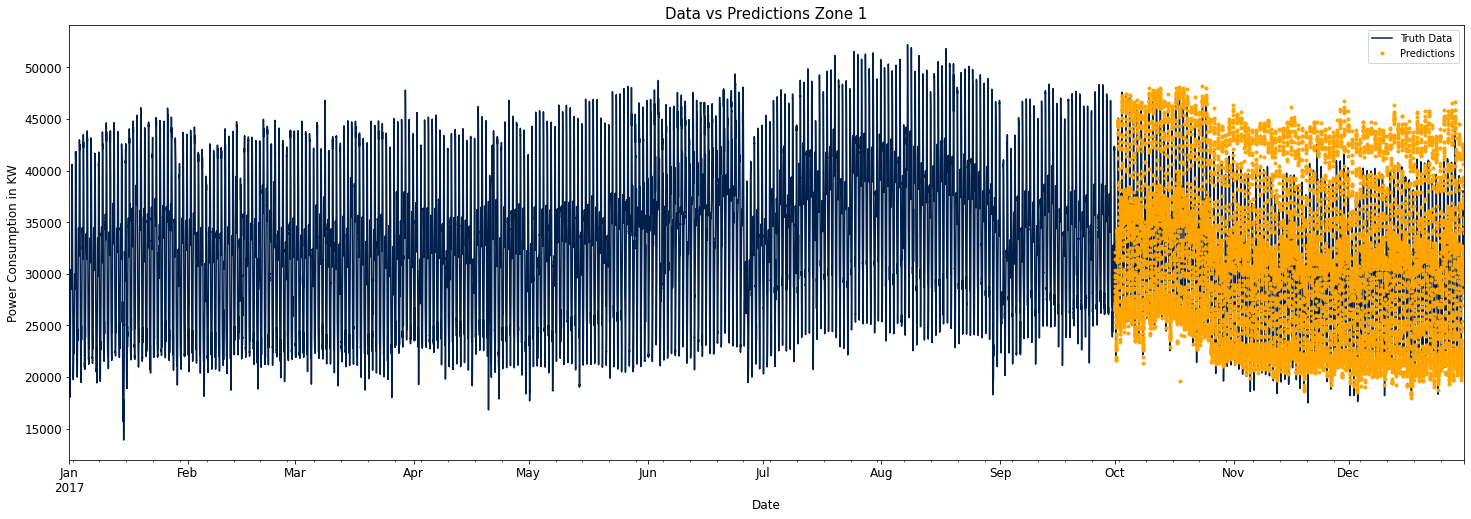

In [75]:
##Printing predictions on chart to visually assess accuracy
ax = df[['PowerConsumption_Zone1']].plot(figsize=(25, 8), color = "#011f4b")
y_test['prediction'].plot(ax=ax, style='.', color = "orange")
plt.legend(['Truth Data', 'Predictions'])

plt.title('Data vs Predictions Zone 1', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Consumption in KW', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

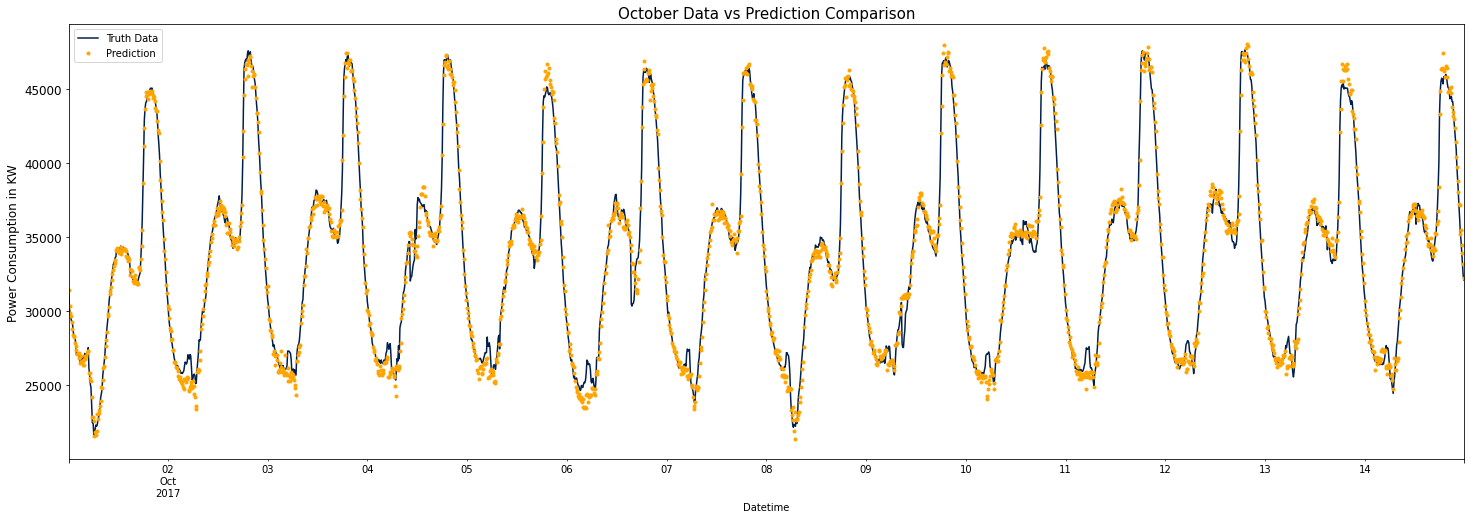

In [76]:
##Printing October predictions on chart to visually assess accuracy
ax = df.loc[(df.index > '10-01-2017') & (df.index < '10-15-2017')]['PowerConsumption_Zone1'] \
    .plot(figsize=(25, 8), title='October Data vs Prediction Comparison', color = "#011f4b")
df.loc[(df.index > '10-01-2017') & (df.index < '10-15-2017')]['prediction'] \
    .plot(style='.', color = "orange")

plt.title('October Data vs Prediction Comparison', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Power Consumption in KW', fontsize=12)
plt.legend(['Truth Data','Prediction'])

plt.show()

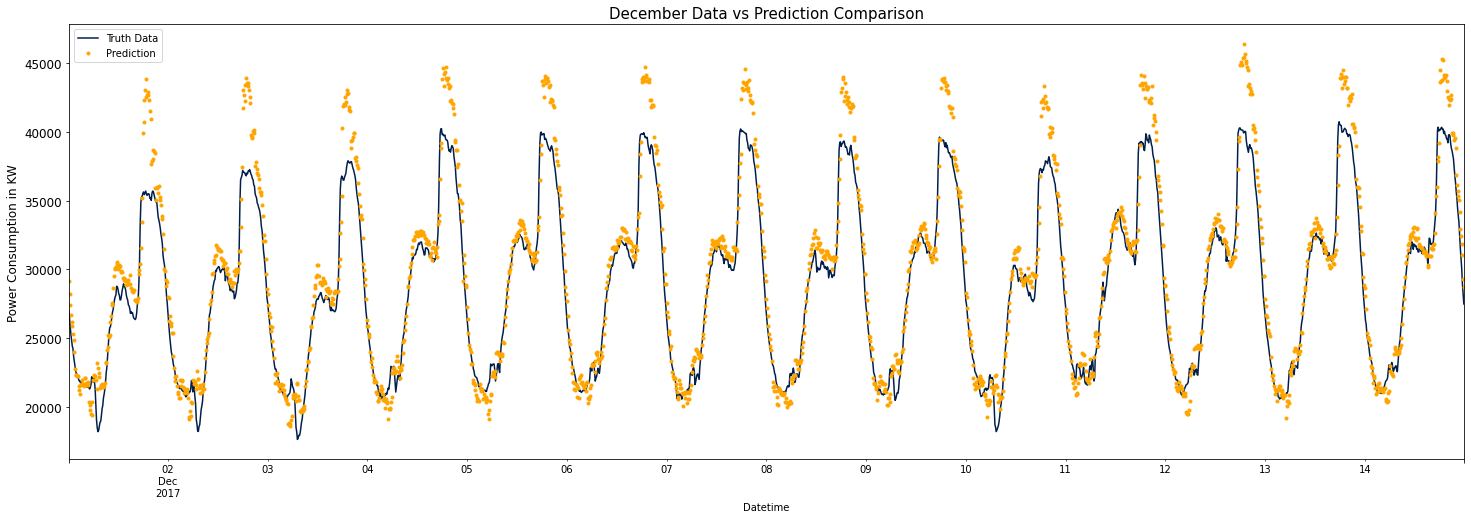

In [77]:
##Printing December predictions on chart to visually assess accuracy
ax = df.loc[(df.index > '12-01-2017') & (df.index < '12-15-2017')]['PowerConsumption_Zone1'] \
    .plot(figsize=(25, 8), title='December Data vs Prediction Comparison', color = "#011f4b")
df.loc[(df.index > '12-01-2017') & (df.index < '12-15-2017')]['prediction'] \
    .plot(style='.', color = "orange")

plt.title('December Data vs Prediction Comparison', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Power Consumption in KW', fontsize=12)
plt.legend(['Truth Data','Prediction'])

plt.show()

In [78]:
##Function to calculate regression metrics, evaluating accuracy
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    mape = (1- metrics.mean_absolute_percentage_error(y_true, y_pred))


    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('MAPE: ', round(mape,4))

In [79]:
#Apply function and print results
regression_results(y_test['PowerConsumption_Zone1'], y_test['prediction'])

explained_variance:  0.944
mean_squared_log_error:  0.0024
r2:  0.9343
MAE:  1135.8112
MSE:  2736674.4376
RMSE:  1654.2897
MAPE:  0.9634
